In [1]:
import tensorflow as tf
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras; import keras.backend
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("Backend ok")

from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import np_utils
from PIL import Image
from scipy import ndimage

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Backend ok


In [2]:
seed = 7
np.random.seed(seed)

# Import MNIST Handwriting Dataset

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_train, height, width = X_train.shape 
num_test = X_test.shape[0]
num_classes = np.unique(y_train).shape[0]

In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

5


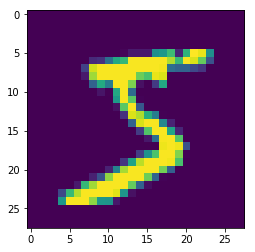

In [4]:
idx = 0
print(y_train[idx])
plt.imshow(X_train[idx])
plt.show()

# Simple MLP Architecture

In [6]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = height*width
X_train_flat = X_train.reshape(num_train, num_pixels).astype('float32')
X_test_flat = X_test.reshape(num_test, num_pixels).astype('float32')

#normalize inputs from 0-255 to 0-1
X_train_flat = X_train_flat/255
X_test_flat = X_test_flat/255

#one-hot encode output
y_train_hot = np_utils.to_categorical(y_train)
y_test_hot = np_utils.to_categorical(y_test)
num_classes = y_test_hot.shape[1]

The model is simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A ReLu activation function is used for the neurons in the hidden layer

A softmax activation function is used on the output layer to turn the outputs into probability-like values

Logaritmic loss is used as the loss function (called "categorical_crossentropy" in Keras) and the efficient ADAM gradient descent algoirthm is used to learn the weights

In [23]:
# design the MLP model
def MLP_model():
    mlp_model = Sequential()
    mlp_model.add(Dense(num_pixels, input_dim=num_pixels, 
                        kernel_initializer='normal', activation='relu'))
    mlp_model.add(Dense(num_classes, 
                        kernel_initializer='normal', activation='softmax'))
    mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return mlp_model

In [24]:
# build the model
model = MLP_model()
model.fit(X_train_flat, y_train_hot, validation_data=(X_test_flat, y_test_hot), 
          epochs=10, batch_size=200, verbose=2)

# evaluation
scores = model.evaluate(X_test_flat, y_test_hot, verbose=0)
print("Baseline Error for MLP Model: {0}%".format(100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 0.2810 - acc: 0.9199 - val_loss: 0.1451 - val_acc: 0.9572
Epoch 2/10
 - 7s - loss: 0.1101 - acc: 0.9682 - val_loss: 0.0984 - val_acc: 0.9705
Epoch 3/10
 - 7s - loss: 0.0696 - acc: 0.9794 - val_loss: 0.0764 - val_acc: 0.9757
Epoch 4/10
 - 7s - loss: 0.0488 - acc: 0.9858 - val_loss: 0.0762 - val_acc: 0.9758
Epoch 5/10
 - 7s - loss: 0.0351 - acc: 0.9902 - val_loss: 0.0642 - val_acc: 0.9800
Epoch 6/10
 - 7s - loss: 0.0257 - acc: 0.9932 - val_loss: 0.0634 - val_acc: 0.9811
Epoch 7/10
 - 7s - loss: 0.0184 - acc: 0.9955 - val_loss: 0.0657 - val_acc: 0.9798
Epoch 8/10
 - 7s - loss: 0.0144 - acc: 0.9968 - val_loss: 0.0571 - val_acc: 0.9824
Epoch 9/10
 - 7s - loss: 0.0093 - acc: 0.9983 - val_loss: 0.0615 - val_acc: 0.9816
Epoch 10/10
 - 7s - loss: 0.0071 - acc: 0.9989 - val_loss: 0.0642 - val_acc: 0.9806
Baseline Error for MLP Model: 1.9399999999999977%


# Simple Convolutional Neural Network

In [5]:
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('th')

Dataset should be reshaped into a shape that is suitable for training a CNN. In Keras, the layers used for 2D convolution expect dimension [pixel]][width][height].

In case of RGB, the [pixel] dimension would be 3. While for the grayscale MNIST dataset, the [pixel] dimension is set to 1

In [6]:
# reshape to suit the Keras CNN input shape
X_train_conv = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_conv = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# mapminmax rescaling
X_train_conv = X_train_conv/255
X_test_conv = X_test_conv/255

#one-hot encode output
y_train_hot = np_utils.to_categorical(y_train)
y_test_hot = np_utils.to_categorical(y_test)
num_classes = y_test_hot.shape[1]

The simple convolutional network structure is as follows:

1. The first hidden layer is a convolutional layer called Convolution2d. It has 32 feature maps, which with the size of 5x5 and a ReLu activation funcion. This is the input layer, expecting images with the structure outlined above [pixels][width][height]

2. Secind hidden layer is 2D MaxPooling layer. It is configured with a pool size of 2x2

3. Third layer is a regularization layer using Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting

4. Next is a layer that converts 2D matrix data into vector called Flatten. It allows the output to be processed by standard fully-connected layers

5. Next is a fully connected layers with 128 neurons and ReLu activation funcition

6. Finally, the output layeer with 10 neurons for 10 classes and a softmax activation function to output a ptobability-like prediction of each class

As before, the model is trained using logarithmic loss function and the ADAM gradient descent algorithm

In [77]:
def CNN_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1,28,28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

In [386]:
#build the model
cnn_model = CNN_model()
#fit the model
cnn_model.fit(X_train_conv, y_train_hot, 
              validation_data=(X_test_conv, y_test_hot),
              epochs=10, batch_size=200, verbose=2
             )
#evaluation of the model
scores = cnn_model.evaluate(X_test_conv, y_test_hot, verbose=0)
print("Error for CNN Model: {0}%".format(100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 154s - loss: 0.2576 - acc: 0.9260 - val_loss: 0.0822 - val_acc: 0.9761
Epoch 2/10
 - 154s - loss: 0.0762 - acc: 0.9773 - val_loss: 0.0553 - val_acc: 0.9836
Epoch 3/10
 - 162s - loss: 0.0538 - acc: 0.9832 - val_loss: 0.0452 - val_acc: 0.9859
Epoch 4/10
 - 169s - loss: 0.0418 - acc: 0.9872 - val_loss: 0.0392 - val_acc: 0.9872
Epoch 5/10
 - 174s - loss: 0.0337 - acc: 0.9894 - val_loss: 0.0364 - val_acc: 0.9881
Epoch 6/10
 - 166s - loss: 0.0289 - acc: 0.9907 - val_loss: 0.0342 - val_acc: 0.9888
Epoch 7/10
 - 171s - loss: 0.0250 - acc: 0.9918 - val_loss: 0.0349 - val_acc: 0.9884
Epoch 8/10
 - 171s - loss: 0.0205 - acc: 0.9934 - val_loss: 0.0323 - val_acc: 0.9896
Epoch 9/10
 - 169s - loss: 0.0180 - acc: 0.9943 - val_loss: 0.0337 - val_acc: 0.9890
Epoch 10/10
 - 184s - loss: 0.0153 - acc: 0.9951 - val_loss: 0.0336 - val_acc: 0.9898
Error for CNN Model: 1.019999999999996%


# Larger Convolutional Neural Network

We will build larger CNN with topology as follows;

1. Convolutional laye with 30 feature maps of size 5x5
2. Pooling layer taking the max over 2x2 patches
3. Convolutional layer with 15 feature maps of size 3x3
4. Pooling layer taking the max over 2x2 pathes
5. Dropout layer with a probability of 20%
6. Flatten layer
7. Fully connected layer with 128 neurons and ReLu activation
8. Fully connected layer with 50 neurons and ReLu activation
9. Output layer

In [7]:
def larger_CNN_model():
    model = Sequential()
    model.add(Conv2D(30, (5,5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(15, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy']
                 )
    return model

In [8]:
#build the model
large_cnn_model = larger_CNN_model()
#fit the model
large_cnn_model.fit(X_train_conv, y_train_hot, 
              validation_data=(X_test_conv, y_test_hot),
              epochs=10, batch_size=200, verbose=2
             )
#evaluation of the model
scores = large_cnn_model.evaluate(X_test_conv, y_test_hot, verbose=0)
print("Error for CNN Model: {0}%".format(100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 153s - loss: 0.3968 - acc: 0.8776 - val_loss: 0.0981 - val_acc: 0.9685
Epoch 2/10
 - 151s - loss: 0.0943 - acc: 0.9707 - val_loss: 0.0577 - val_acc: 0.9808
Epoch 3/10
 - 137s - loss: 0.0683 - acc: 0.9793 - val_loss: 0.0370 - val_acc: 0.9882
Epoch 4/10
 - 144s - loss: 0.0565 - acc: 0.9823 - val_loss: 0.0337 - val_acc: 0.9891
Epoch 5/10
 - 148s - loss: 0.0476 - acc: 0.9851 - val_loss: 0.0299 - val_acc: 0.9904
Epoch 6/10
 - 148s - loss: 0.0434 - acc: 0.9864 - val_loss: 0.0290 - val_acc: 0.9897
Epoch 7/10
 - 148s - loss: 0.0387 - acc: 0.9875 - val_loss: 0.0273 - val_acc: 0.9912
Epoch 8/10
 - 148s - loss: 0.0342 - acc: 0.9890 - val_loss: 0.0240 - val_acc: 0.9920
Epoch 9/10
 - 144s - loss: 0.0323 - acc: 0.9900 - val_loss: 0.0214 - val_acc: 0.9933
Epoch 10/10
 - 145s - loss: 0.0280 - acc: 0.9907 - val_loss: 0.0212 - val_acc: 0.9937
Error for CNN Model: 0.6299999999999955%


# Test on Image

In [11]:
def center_image(img, resize_to=(28,28)):
    image = img.copy()
    image.thumbnail(resize_to, Image.ANTIALIAS)
    image_array = 1-(np.array(image)/255)
    
    height, width = image_array.shape
    resize_height, resize_width = resize_to
    if height < resize_height:
        pad_height = np.zeros([resize_height-height, width])
        image_array = np.concatenate((pad_height, image_array), axis=0)
    if width < resize_width:
        pad_width = np.zeros([height, resize_width-width])
        image_array = np.concatenate((pad_width, image_array), axis=1)

    x, y = ndimage.measurements.center_of_mass(image_array)
    x, y = int(x), int(y)
    #pad on height
    if x<int(resize_height/2):
        pad_height = np.zeros([int(resize_height/2)-x,resize_height])
        image_array = np.concatenate((pad_height, image_array), axis=0)
        image_array = image_array[0:resize_height,:]
    elif x>int(resize_height/2):
        pad_height = np.zeros([x-int(resize_height/2),resize_height])
        image_array = np.concatenate((image_array, pad_height), axis=0)
        image_array = image_array[x-int(resize_height/2):,:]
    
    #pad on width    
    if y<int(resize_width/2):
        pad_width = np.zeros([resize_width,int(resize_width/2)-y])
        image_array = np.concatenate((pad_width, image_array), axis=1)
        image_array = image_array[:,0:resize_width]
    elif y>int(resize_width/2):
        pad_width = np.zeros([resize_width,y-int(resize_width/2)])
        image_array = np.concatenate((image_array, pad_width), axis=1)
        image_array = image_array[:,y-int(resize_width/2):]
    
    return image_array

Predicted: 6


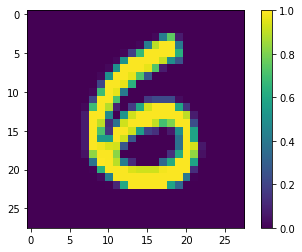

In [9]:
index = int(1000*np.abs(np.random.randn()))
prediction = large_cnn_model.predict(X_test_conv[index].reshape(1,1,28,28))
print("Predicted: {0}".format(np.argmax(prediction)))

plt.imshow(X_test_conv[index].reshape(28, 28))
plt.savefig('hw_digit_7.png')
plt.colorbar()
plt.show()

0: 0.02%
1: 0.0%
2: 0.01%
3: 0.0%
4: 0.14%
5: 0.08%
6: 99.68%
7: 0.0%
8: 0.07%
9: 0.0%
Predicted: 6


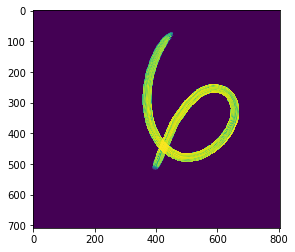

In [35]:
image = Image.open('hw_digit_5.png').convert('L')
image_array = center_image(image)
prediction = large_cnn_model.predict(image_array.reshape(1,1,28,28))
for i, j in enumerate(prediction[0]):
    print("{}: {}%".format(i,np.round(j*100,2)))
print("Predicted: {0}".format(np.argmax(prediction)))
plt.imshow(1-(np.array(image)/255))
plt.show()